# EXP04-v2: Retrieval Architecture Enhancement

- **Date**: 2026-02-10
- **Prerequisite**: EXP04 C_verbatim (Metadata + Verbatim Prompt, KW_Acc=0.664)
- **Goal**: 검색 아키텍처 개선으로 Context Recall 0.70 → 0.85+ 달성
- **Primary Metric**: Context Recall (검색 품질), Keyword Accuracy (최종 정확도)

## 변경 이력
- EXP04 (V3): 생성 개선 (Metadata+Verbatim) → KW_Acc 0.443→0.664 (+34.9%)
- **EXP04-v2**: 검색 아키텍처 개선으로 CR 0.70 병목 해소

## 1. 실험 설계 (Experiment Design)

### 1.1 실험 배경 & 실패 원인 분석

EXP04에서 **생성 품질**은 크게 개선(KW_Acc +34.9%)되었으나, **검색 품질**(CR=0.70)이 병목:
- **30%의 질문**에서 정답 컨텍스트가 top-15에 포함되지 않음
- chunk_size=500 고정 분할이 RFP의 절/항목/표 구조를 무시하여 정답이 쪼개짐
- 표(Table) 데이터의 Dense 검색 유사도가 낮음

### 1.2 실패 유형 가설

| 유형 | 설명 | 예상 비율 | 해결 전략 |
|------|------|----------|----------|
| **인접 분산** | 정답이 현재 청크와 인접 청크에 걸쳐 존재 | 높음(→진단 후 판정) | Parent-Child + Window |
| **구조 단절** | '가.항목명'과 '내용'이 서로 다른 청크에 분리 | 중간 | Section-aware + Header prefix |
| **표 누락** | 정답이 표에 있으나 Dense 매칭 실패 | 일부(→진단 후 판정) | Table dual-index |

→ **Diagnostic Analysis(섹션 4)**에서 각 유형의 실제 비율을 먼저 측정 후 Config를 확정합니다.

### 1.3 Ablation Configs (초기안 → 진단 결과 반영)

**초기안** (6개):

| Config | 이름 | 핵심 변경 |
|--------|------|----------|
| A | baseline | EXP04 C_verbatim 재현 (chunk=500) |
| B | large_chunk | chunk_size=1000, overlap=200 |
| C0 | parent_child | child=300 검색, parent=1500 생성 |
| C1 | parent_child_window | C0 + 인접 parent ±1 윈도우 확장 |
| D0 | section_aware | 절/항목 기반 분할 + 헤더 프리픽스 본문 주입 |
| T0 | table_dual | D0 + 표-to-text 이중 인덱싱 |

→ 진단 결과 C0/C1 제거 (4.4절 참조). **최종 4개 Config로 실행.**

### 1.4 고정 변수 (EXP04 C_verbatim 계승)

| 변수 | 값 | 근거 |
|------|-----|------|
| Alpha (BM25 weight) | 0.5 | EXP02 확정 |
| Top-K (최종) | 15 | EXP02 확정 |
| Generation LLM | gpt-5-mini | 전 실험 동일 |
| Prompt | VERBATIM + Fact Sheet | EXP04 Best |

### 1.5 가설

1. **H1**: Large Chunk(1000)으로 CR 소폭 개선 (구조 단절 감소)
2. **H2**: Section-aware + Header prefix로 구조적 질문 CR 개선
3. **H3**: Table dual-index로 표 관련 질문 정확도 대폭 개선 (87.5% 실패 해소)
4. **H4**: 최종 Config(T0)에서 KW_Acc 0.75+ 달성

In [7]:
# ============================================================
# 2. Setup
# ============================================================
import os
import re
import gc
import json
import time
import shutil
import hashlib
import warnings
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdfplumber

from datasets import Dataset
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_community.retrievers import BM25Retriever

from ragas import evaluate
from ragas.metrics import Faithfulness, ResponseRelevancy, ContextRecall
from ragas.run_config import RunConfig

from bidflow.parsing.preprocessor import TextPreprocessor
from bidflow.eval.ragas_runner import RagasRunner, FixedTempChatOpenAI

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print('[OK] Setup complete')

[OK] Setup complete


In [8]:
# ============================================================
# 3. Config & Data Load
# ============================================================
EXP04_REPORT_PATH = '../data/experiments/exp04_report.json'
GOLDEN_TESTSET_PATH = '../data/experiments/golden_testset.csv'
CHROMA_BASE_PATH = '../data/chroma_exp/exp04v2'

OUT_REPORT_PATH = '../data/experiments/exp04v2_report.json'
OUT_CSV_PATH = '../data/experiments/exp04v2_results.csv'
OUT_FIG_PATH = '../data/experiments/exp04v2_results.png'

EMBED_MODEL = 'text-embedding-3-small'
GEN_MODEL = 'gpt-5-mini'
UTIL_MODEL = 'gpt-4o-mini'

ALPHA = 0.5
TOP_K = 15

# ===== EXP04 Prerequisite =====
print('=' * 60)
print('EXP04 Prerequisite (C_verbatim)')
print('=' * 60)

with open(EXP04_REPORT_PATH, 'r', encoding='utf-8') as f:
    exp04 = json.load(f)

exp04_best = exp04['best_config']
FACT_SHEET_DATA = exp04['meta']['fact_sheet']
SAMPLE_FILE = exp04['meta']['sample_file']

# Fact Sheet 문자열
fact_lines = []
for key, val in FACT_SHEET_DATA.items():
    if val and val != '미확인':
        fact_lines.append(f'- {key}: {val}')
FACT_SHEET = '\n'.join(fact_lines)

print(f'  EXP04 Best: {exp04_best["config"]} (KW_Acc={exp04_best["keyword_accuracy"]:.4f})')
print(f'  Fact Sheet:')
print(f'  {FACT_SHEET}')

# ===== Golden Testset =====
golden_df = pd.read_csv(GOLDEN_TESTSET_PATH)
golden_df = golden_df[~golden_df['ground_truth'].str.contains(r'\[여기에', na=False)]
print(f'\n  Test cases: {len(golden_df)}')
print(f'  PDF: {os.path.basename(SAMPLE_FILE)}')

EXP04 Prerequisite (C_verbatim)
  EXP04 Best: C_verbatim (KW_Acc=0.6640)
  Fact Sheet:
  - 사업명: 고려대학교 차세대 포털·학사 정보시스템 구축 사업
- 발주처: 고려대학교
- 사업기간: 계약일로부터 24개월 이내
- 사업예산: 11,270,000,000원 (V.A.T 포함, 3년 분할 지급)
- 입찰방식: 제한 경쟁 입찰(협상에 의한 계약)

  Test cases: 30
  PDF: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf


In [9]:
# ============================================================
# Helper Functions
# ============================================================
def robust_rmtree(path):
    if not os.path.exists(path): return
    for _ in range(5):
        try: shutil.rmtree(path); return
        except PermissionError: gc.collect(); time.sleep(1)
        except Exception: return


def table_to_markdown(table_data):
    if not table_data or len(table_data) < 1:
        return ''
    max_cols = max(len(row) for row in table_data)
    rows = []
    for row in table_data:
        clean = []
        for cell in row:
            c = str(cell).strip().replace('\n', ' ').replace('|', '/') if cell else ''
            clean.append(c if c != 'None' else '')
        while len(clean) < max_cols:
            clean.append('')
        rows.append(clean)
    if all(all(c == '' for c in row) for row in rows):
        return ''
    lines = []
    lines.append('| ' + ' | '.join(rows[0]) + ' |')
    lines.append('| ' + ' | '.join(['---'] * max_cols) + ' |')
    for row in rows[1:]:
        lines.append('| ' + ' | '.join(row) + ' |')
    return '\n'.join(lines)


def table_to_text(table_data):
    """표를 검색 친화적인 선형 텍스트로 변환 (행 단위 문장)"""
    if not table_data or len(table_data) < 2:
        return ''
    headers = [str(c).strip() if c else '' for c in table_data[0]]
    lines = []
    for row in table_data[1:]:
        parts = []
        for i, cell in enumerate(row):
            val = str(cell).strip() if cell else ''
            if val and val != 'None':
                header = headers[i] if i < len(headers) and headers[i] else ''
                if header:
                    parts.append(f'{header}: {val}')
                else:
                    parts.append(val)
        if parts:
            lines.append(', '.join(parts))
    return '. '.join(lines)


def strip_meta_prefix(text):
    if text.startswith('[페이지:'):
        nl = text.find('\n')
        if nl >= 0:
            text = text[nl + 1:]
    if text.startswith('[표]\n'):
        text = text[4:]
    if text.startswith('[표-텍스트]\n'):
        text = text[8:]
    # Section header prefix도 제거하지 않음 (생성에 유용)
    return text


def _doc_key(doc):
    meta = getattr(doc, 'metadata', {}) or {}
    chunk_id = meta.get('chunk_id')
    if chunk_id:
        return f'chunk:{chunk_id}'
    digest = hashlib.sha1(doc.page_content.encode('utf-8')).hexdigest()[:16]
    return f'fallback:{digest}'


def rrf_merge(bm25_docs, vector_docs, w_bm25, w_vector, top_k, k=60):
    scores = defaultdict(float)
    doc_map = {}
    for rank, doc in enumerate(bm25_docs):
        key = _doc_key(doc)
        scores[key] += w_bm25 * (1 / (rank + k))
        doc_map[key] = doc
    for rank, doc in enumerate(vector_docs):
        key = _doc_key(doc)
        scores[key] += w_vector * (1 / (rank + k))
        if key not in doc_map:
            doc_map[key] = doc
    sorted_keys = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    return [doc_map[k_] for k_ in sorted_keys[:top_k]]


def calculate_keyword_accuracy(answers, ground_truths):
    scores = []
    for answer, gt in zip(answers, ground_truths):
        gt_words = [w for w in gt.lower().split() if len(w) > 1]
        if not gt_words:
            scores.append(0.0)
            continue
        answer_lower = answer.lower()
        matched = sum(1 for w in gt_words if w in answer_lower)
        scores.append(matched / len(gt_words))
    return float(np.mean(scores))


def extract_metric(val):
    if isinstance(val, (list, tuple)): return float(np.mean(val))
    if hasattr(val, 'mean'): return float(val.mean())
    return float(val) if val is not None else 0.0


def parse_json_response(text):
    text = text.strip()
    if '```' in text:
        match = re.search(r'```(?:json)?\s*\n?(.*?)\n?```', text, re.DOTALL)
        if match:
            text = match.group(1).strip()
    return json.loads(text)


print('[OK] Helper functions ready')

[OK] Helper functions ready


## 4. Diagnostic Analysis (실패 유형 진단)

실험 우선순위를 결정하기 위해, 현재 파이프라인(chunk=500)의 **검색 실패 패턴**을 먼저 분석합니다.

### 진단 질문
1. **인접 청크 비율**: top-15에 정답이 없는 케이스 중, 정답이 인접 청크(±1)에 있는 비율은?
2. **표 질문 비율**: top-15에 정답이 없는 케이스 중, 정답이 표에 있는 질문의 비율은?

→ 인접 비율이 높으면 **C1(윈도우 확장)** 최우선, 표 비율이 높으면 **T0(표 이중화)** 우선

In [10]:
# ============================================================
# 4.1 진단용 인덱스 구축 (EXP04 동일: chunk=500, T+M)
# ============================================================
preprocessor = TextPreprocessor()

# PDF 전체 파싱
with pdfplumber.open(SAMPLE_FILE) as pdf:
    page_texts = []
    page_tables_raw = []
    for i, page in enumerate(pdf.pages):
        raw_text = page.extract_text(layout=True) or ''
        norm = preprocessor.normalize(raw_text)
        page_texts.append((i + 1, norm))
        tables = page.extract_tables() or []
        for j, tbl in enumerate(tables):
            if tbl and any(any(cell for cell in row) for row in tbl):
                page_tables_raw.append((i + 1, j, tbl))

# Full text + page map
full_text = ''
page_map = []
for page_no, text in page_texts:
    start = len(full_text)
    full_text += text + '\n\n'
    end = len(full_text)
    page_map.append((start, end, page_no))


def get_page_for_position(char_idx, page_map):
    for start, end, page_no in page_map:
        if start <= char_idx < end:
            return page_no
    return 1


# 500자 청킹 (Baseline)
splitter_500 = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50,
    separators=['\n\n', '\n', '.', ' ', '']
)
plain_chunks_500 = splitter_500.split_text(full_text)

# 청크에 위치 정보 부여
diag_docs = []
search_from = 0
for i, c in enumerate(plain_chunks_500):
    idx = full_text.find(c, search_from)
    if idx < 0:
        idx = full_text.find(c[:80], search_from)
    if idx < 0:
        idx = max(search_from, 0)
    page_no = get_page_for_position(idx, page_map)
    text = f'[페이지: {page_no}]\n{c}'
    meta = {
        'chunk_id': f'text_{i}',
        'chunk_idx': i,
        'page_no': page_no,
        'char_start': idx,
        'char_end': idx + len(c),
        'content_type': 'text'
    }
    diag_docs.append(Document(page_content=text, metadata=meta))
    search_from = idx + 1

# 표 청크 추가
table_chunk_ids = set()
for pg_no, t_idx, tbl in page_tables_raw:
    md = table_to_markdown(tbl)
    if md and len(md.strip()) > 30:
        cid = f'table_{pg_no}_{t_idx}'
        text = f'[페이지: {pg_no}]\n[표]\n{md}'
        meta = {'chunk_id': cid, 'chunk_idx': -1, 'page_no': pg_no,
                'content_type': 'table'}
        diag_docs.append(Document(page_content=text, metadata=meta))
        table_chunk_ids.add(cid)

print(f'[OK] 진단용 인덱스: text={len(plain_chunks_500)}, table={len(table_chunk_ids)}, total={len(diag_docs)}')

[OK] 진단용 인덱스: text=591, table=414, total=1005


In [11]:
# ============================================================
# 4.2 진단: 질문별 검색 실패 유형 분류
# ============================================================
DIAG_CHROMA = os.path.join(CHROMA_BASE_PATH, 'diag')
robust_rmtree(DIAG_CHROMA)
os.makedirs(DIAG_CHROMA, exist_ok=True)

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)
diag_db = Chroma(
    persist_directory=DIAG_CHROMA,
    embedding_function=embeddings,
    collection_name='diag',
)
diag_db.add_documents(diag_docs)

bm25_diag = BM25Retriever.from_documents(diag_docs)
bm25_diag.k = TOP_K * 4

print('[진단 검색 시작]')
diag_results = []

for _, row in golden_df.iterrows():
    q = row['question']
    gt = str(row['ground_truth']).lower()
    gt_words = [w for w in gt.split() if len(w) > 1]

    # Hybrid 검색 (top-15)
    bm25_docs = bm25_diag.invoke(q)
    vec_docs = diag_db.as_retriever(search_kwargs={'k': TOP_K * 4}).invoke(q)
    retrieved = rrf_merge(bm25_docs, vec_docs, ALPHA, 1.0 - ALPHA, TOP_K)

    # top-15 텍스트
    top15_text = ' '.join([d.page_content.lower() for d in retrieved])
    top15_ids = {d.metadata.get('chunk_idx', -1) for d in retrieved}
    top15_match = sum(1 for w in gt_words if w in top15_text) / max(len(gt_words), 1)

    # top-15 인접 청크(±1) 텍스트 (text 청크만)
    neighbor_ids = set()
    for idx in top15_ids:
        if idx >= 0:
            neighbor_ids.add(idx - 1)
            neighbor_ids.add(idx + 1)
    neighbor_ids -= top15_ids  # 이미 top-15에 있는 건 제외
    neighbor_ids.discard(-1)

    neighbor_docs = [d for d in diag_docs
                     if d.metadata.get('chunk_idx', -1) in neighbor_ids]
    neighbor_text = ' '.join([d.page_content.lower() for d in neighbor_docs])

    # top-15 + 인접 합치면 매칭이 얼마나 올라가는지
    expanded_text = top15_text + ' ' + neighbor_text
    expanded_match = sum(1 for w in gt_words if w in expanded_text) / max(len(gt_words), 1)

    # 전체 문서에서의 매칭 (ceiling)
    full_match = sum(1 for w in gt_words if w in full_text.lower()) / max(len(gt_words), 1)

    # 표 청크에 정답이 있는지
    table_docs_all = [d for d in diag_docs if d.metadata.get('content_type') == 'table']
    table_text = ' '.join([d.page_content.lower() for d in table_docs_all])
    table_match = sum(1 for w in gt_words if w in table_text) / max(len(gt_words), 1)

    # 검색 실패 여부
    is_retrieval_miss = top15_match < 0.5

    diag_results.append({
        'question': q[:40],
        'category': row.get('category', ''),
        'difficulty': row.get('difficulty', ''),
        'top15_kw_match': top15_match,
        'expanded_kw_match': expanded_match,
        'neighbor_gain': expanded_match - top15_match,
        'full_doc_match': full_match,
        'table_match': table_match,
        'is_retrieval_miss': is_retrieval_miss,
        'has_table_answer': table_match > 0.3,
    })

diag_df = pd.DataFrame(diag_results)
print(f'\n[OK] 진단 완료: {len(diag_df)}개 질문')

[진단 검색 시작]

[OK] 진단 완료: 30개 질문


In [12]:
# ============================================================
# 4.3 진단 결과 분석
# ============================================================
print('=' * 70)
print('[Diagnostic] 검색 실패 유형 분석')
print('=' * 70)

n_total = len(diag_df)
n_miss = diag_df['is_retrieval_miss'].sum()
miss_df = diag_df[diag_df['is_retrieval_miss']]

print(f'\n  전체 질문: {n_total}개')
print(f'  검색 실패 (top-15 KW매칭 < 50%): {n_miss}개 ({n_miss/n_total*100:.1f}%)')

# 질문 1: 인접 청크 비율
print(f'\n--- [Q1] 인접 청크(±1) 확장 효과 ---')
if n_miss > 0:
    n_neighbor_helps = (miss_df['neighbor_gain'] > 0.1).sum()
    print(f'  검색 실패 {n_miss}개 중, 인접 확장으로 10%p+ 개선: {n_neighbor_helps}개 ({n_neighbor_helps/n_miss*100:.1f}%)')
    avg_gain = miss_df['neighbor_gain'].mean()
    print(f'  실패 케이스 평균 인접 확장 효과: +{avg_gain:.3f}')
else:
    print('  검색 실패 케이스 없음')

# 전체 기준으로도
print(f'\n  [전체 기준]')
print(f'  top-15 평균 KW매칭: {diag_df["top15_kw_match"].mean():.3f}')
print(f'  +인접 확장 평균: {diag_df["expanded_kw_match"].mean():.3f} (gain: +{diag_df["neighbor_gain"].mean():.3f})')
print(f'  전체 문서 ceiling: {diag_df["full_doc_match"].mean():.3f}')

# 질문 2: 표 질문 비율
print(f'\n--- [Q2] 표(Table) 관련 질문 ---')
n_table = diag_df['has_table_answer'].sum()
print(f'  정답이 표에 30%+ 포함된 질문: {n_table}개 ({n_table/n_total*100:.1f}%)')
if n_miss > 0:
    n_table_miss = miss_df['has_table_answer'].sum()
    print(f'  검색 실패 중 표 관련: {n_table_miss}개 ({n_table_miss/n_miss*100:.1f}%)')

# 상세 테이블
print(f'\n--- [Detail] 질문별 진단 ---')
print(f'{"Question":<42} {"Diff":>6} {"Top15":>6} {"±Nbr":>6} {"Gain":>6} {"Tbl":>5} {"Miss":>5}')
print('-' * 80)
for _, r in diag_df.iterrows():
    miss_flag = '***' if r['is_retrieval_miss'] else ''
    tbl_flag = 'T' if r['has_table_answer'] else ''
    print(f'{r["question"]:<42} {r["difficulty"]:>6} {r["top15_kw_match"]:>6.2f} '
          f'{r["expanded_kw_match"]:>6.2f} {r["neighbor_gain"]:>+6.2f} {tbl_flag:>5} {miss_flag:>5}')

# 우선순위 판정
print(f'\n{"=" * 70}')
print('[Priority Decision]')
avg_neighbor_gain_miss = miss_df['neighbor_gain'].mean() if n_miss > 0 else 0
table_miss_ratio = (miss_df['has_table_answer'].sum() / n_miss * 100) if n_miss > 0 else 0

if avg_neighbor_gain_miss > 0.05:
    print(f'  → 인접 확장 효과 높음 (avg gain={avg_neighbor_gain_miss:.3f}): C1(Window) 최우선')
else:
    print(f'  → 인접 확장 효과 제한적: C0(Parent-Child) 기본으로 충분')

if table_miss_ratio > 30:
    print(f'  → 표 관련 실패 비율 높음 ({table_miss_ratio:.0f}%): T0(표 이중화) C 다음 우선')
else:
    print(f'  → 표 관련 실패 비율 낮음 ({table_miss_ratio:.0f}%): T0은 후순위')

[Diagnostic] 검색 실패 유형 분석

  전체 질문: 30개
  검색 실패 (top-15 KW매칭 < 50%): 9개 (30.0%)

--- [Q1] 인접 청크(±1) 확장 효과 ---
  검색 실패 9개 중, 인접 확장으로 10%p+ 개선: 4개 (44.4%)
  실패 케이스 평균 인접 확장 효과: +0.221

  [전체 기준]
  top-15 평균 KW매칭: 0.615
  +인접 확장 평균: 0.704 (gain: +0.088)
  전체 문서 ceiling: 0.917

--- [Q2] 표(Table) 관련 질문 ---
  정답이 표에 30%+ 포함된 질문: 29개 (96.7%)
  검색 실패 중 표 관련: 8개 (88.9%)

--- [Detail] 질문별 진단 ---
Question                                     Diff  Top15   ±Nbr   Gain   Tbl  Miss
--------------------------------------------------------------------------------
본 사업의 프로젝트 명은 무엇인가?                          easy   0.33   1.00  +0.67     T   ***
사업의 수행 기간은 얼마인가?                             easy   0.33   0.33  +0.00     T   ***
입찰 참가 자격 중 실적 관련 요구사항은?                    medium   0.62   0.75  +0.12     T      
기술능력평가와 입찰가격평가의 배점 비율은?                    medium   0.50   0.50  +0.00     T      
사업 수행 장소는 어디인가?                              easy   0.33   0.33  +0.00     T   ***
하자보수 기간은?                        

### 4.4 진단 결과 해석 및 Config 우선순위 조정

**Q1 결과: 인접 청크 확장 → 효과 미미, C0/C1 보류**

- 검색 실패 8개 중 인접 확장(±1)으로 10%p+ 개선: **1개(12.5%)**뿐
- 나머지 7개는 gain=0.00 (인접 청크에도 정답 없음)
- 평균 gain +0.083은 1건(사업명: +0.67)이 왜곡한 수치
- **결론**: Parent-Child + Window(C0, C1)은 ROI 낮아 **보류** (8.1절 추가 실험에서 별도 검증)

**Q2 결과: 표 관련 실패 → 핵심 원인, T0 우선**

- 검색 실패 8개 중 **7개(87.5%)**가 표 관련
- 무상유지보수기간(0.00), 사업예산(0.00), 배점 비율(0.25), 사업비 지급 비율(0.22) 등
  사업개요/평가기준/예산 표에 정답이 있으나 Dense 검색이 Markdown 표와 질문을 매칭 실패
- **결론**: Section-aware + Header prefix(D0)와 Table dual-index(T0)가 **최우선**

**수정된 Config 구성**:

| Config | 이름 | 상태 | 사유 |
|--------|------|------|------|
| A | baseline (chunk=500) | 유지 | 비교 기준 |
| B | large_chunk (1000) | 유지 | 단순 확장 효과 확인 |
| C0 | parent_child | **보류** | 인접 확장 효과 1/8만 개선 → 8.1절 추가 실험 |
| C1 | pc_window | **보류** | C0 위에 윈도우 추가, ROI 낮음 → 8.1절 추가 실험 |
| D0 | section_aware | 유지 | 헤더 프리픽스로 구조 보존 |
| T0 | table_dual | 유지 | 핵심 — 87.5% 실패 원인 해결 |

## 5. Retrieval Architecture 구현

### 5.1 문서 빌더 (Config별)
- **A/baseline**: chunk=500, overlap=50 (기존)
- **B/large_chunk**: chunk=1000, overlap=200
- **C0/parent_child**: child=300, parent=1500
- **C1/parent_child_window**: C0 + 인접 parent ±1
- **D0/section_aware**: 절/항목 기반 분할 + 헤더 프리픽스 주입
- **T0/table_dual**: D0 + 표-to-text 이중 인덱싱

In [13]:
# ============================================================
# 5.1 문서 빌더: 각 Config별 청킹 전략
# ============================================================

def build_docs_baseline(chunk_size=500, chunk_overlap=50):
    """A/B: 고정 크기 청킹 (기존 방식)"""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap,
        separators=['\n\n', '\n', '.', ' ', '']
    )
    chunks = splitter.split_text(full_text)
    docs = []
    search_from = 0
    for i, c in enumerate(chunks):
        idx = full_text.find(c, search_from)
        if idx < 0: idx = full_text.find(c[:80], search_from)
        if idx < 0: idx = max(search_from, 0)
        page_no = get_page_for_position(idx, page_map)
        text = f'[페이지: {page_no}]\n{c}'
        meta = {'chunk_id': f'text_{i}', 'chunk_idx': i, 'page_no': page_no,
                'content_type': 'text'}
        docs.append(Document(page_content=text, metadata=meta))
        search_from = idx + 1

    # 표 추가
    for pg_no, t_idx, tbl in page_tables_raw:
        md = table_to_markdown(tbl)
        if md and len(md.strip()) > 30:
            text = f'[페이지: {pg_no}]\n[표]\n{md}'
            meta = {'chunk_id': f'table_{pg_no}_{t_idx}', 'page_no': pg_no,
                    'content_type': 'table'}
            docs.append(Document(page_content=text, metadata=meta))
    return docs


def build_docs_parent_child(child_size=300, child_overlap=50,
                            parent_size=1500, parent_overlap=200):
    """C0/C1: Parent-Child 청킹"""
    # Parent 청크 생성
    parent_splitter = RecursiveCharacterTextSplitter(
        chunk_size=parent_size, chunk_overlap=parent_overlap,
        separators=['\n\n', '\n', '.', ' ', '']
    )
    parent_chunks = parent_splitter.split_text(full_text)

    parents = []  # (parent_id, text, page_no, char_start)
    search_from = 0
    for i, pc in enumerate(parent_chunks):
        idx = full_text.find(pc, search_from)
        if idx < 0: idx = full_text.find(pc[:80], search_from)
        if idx < 0: idx = max(search_from, 0)
        page_no = get_page_for_position(idx, page_map)
        parents.append((f'parent_{i}', pc, page_no, idx))
        search_from = idx + 1

    # Child 청크 생성 (각 parent 내에서)
    child_splitter = RecursiveCharacterTextSplitter(
        chunk_size=child_size, chunk_overlap=child_overlap,
        separators=['\n\n', '\n', '.', ' ', '']
    )

    child_docs = []  # 검색용 (child)
    parent_docs = {}  # parent_id → Document (생성용)

    for pid, p_text, p_page, p_start in parents:
        # Parent document 저장
        parent_docs[pid] = Document(
            page_content=f'[페이지: {p_page}]\n{p_text}',
            metadata={'chunk_id': pid, 'page_no': p_page, 'content_type': 'parent'}
        )

        # Child 분할
        children = child_splitter.split_text(p_text)
        for j, child in enumerate(children):
            child_page = get_page_for_position(
                p_start + p_text.find(child), page_map
            )
            child_docs.append(Document(
                page_content=f'[페이지: {child_page}]\n{child}',
                metadata={
                    'chunk_id': f'{pid}_child_{j}',
                    'parent_id': pid,
                    'parent_idx': int(pid.split('_')[1]),
                    'page_no': child_page,
                    'content_type': 'child'
                }
            ))

    # 표 청크도 child로 추가 (표는 parent 없이 독립)
    for pg_no, t_idx, tbl in page_tables_raw:
        md = table_to_markdown(tbl)
        if md and len(md.strip()) > 30:
            child_docs.append(Document(
                page_content=f'[페이지: {pg_no}]\n[표]\n{md}',
                metadata={'chunk_id': f'table_{pg_no}_{t_idx}', 'parent_id': None,
                          'page_no': pg_no, 'content_type': 'table'}
            ))

    print(f'  Parents: {len(parent_docs)}, Children: {len(child_docs)}')
    return child_docs, parent_docs, parents


def _detect_section_headers(text):
    """RFP 구조 감지: 장/절/항목 헤더를 찾아 (position, header_text) 반환"""
    headers = []
    patterns = [
        (r'^(제\s*\d+\s*장[^\n]*)', 1),           # 제1장, 제2장...
        (r'^(제\s*\d+\s*절[^\n]*)', 2),           # 제1절, 제2절...
        (r'^(\d+\.\s+[가-힣][^\n]{2,30})', 2),    # 1. 사업개요, 2. 추진배경
        (r'^(\d+\.\d+\.?\s+[^\n]{2,30})', 3),    # 1.1 사업기간
        (r'^([가-하]\.\s*[^\n]{2,30})', 3),        # 가. 추진일정, 나. 사업범위
    ]
    for line_start in re.finditer(r'^', text, re.MULTILINE):
        pos = line_start.start()
        line = text[pos:pos+80]
        for pat, level in patterns:
            m = re.match(pat, line)
            if m:
                headers.append((pos, m.group(1).strip(), level))
                break
    return headers


def build_docs_section_aware(chunk_size=800, chunk_overlap=100, add_table_text=False):
    """D0/T0: 섹션 인식 청킹 + 헤더 프리픽스 본문 주입"""
    headers = _detect_section_headers(full_text)
    print(f'  감지된 섹션 헤더: {len(headers)}개')

    # 각 위치에 대해 현재 활성 헤더 체인 계산
    def get_header_chain(pos):
        """주어진 위치에서 활성화된 헤더 체인 반환"""
        active = {}  # level → header_text
        for h_pos, h_text, h_level in headers:
            if h_pos <= pos:
                active[h_level] = h_text
                # 하위 레벨 초기화
                for l in list(active.keys()):
                    if l > h_level:
                        del active[l]
            else:
                break
        chain = [active[l] for l in sorted(active.keys())]
        return ' > '.join(chain) if chain else ''

    # 청킹
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap,
        separators=['\n\n', '\n', '.', ' ', '']
    )
    chunks = splitter.split_text(full_text)

    docs = []
    search_from = 0
    for i, c in enumerate(chunks):
        idx = full_text.find(c, search_from)
        if idx < 0: idx = full_text.find(c[:80], search_from)
        if idx < 0: idx = max(search_from, 0)
        page_no = get_page_for_position(idx, page_map)

        # 헤더 체인을 본문 앞에 프리픽스로 주입
        header_chain = get_header_chain(idx)
        if header_chain:
            text = f'[페이지: {page_no}]\n[{header_chain}]\n{c}'
        else:
            text = f'[페이지: {page_no}]\n{c}'

        meta = {'chunk_id': f'sec_{i}', 'chunk_idx': i, 'page_no': page_no,
                'section': header_chain, 'content_type': 'text'}
        docs.append(Document(page_content=text, metadata=meta))
        search_from = idx + 1

    # 표: 원본 Markdown + (옵션) table-to-text 이중 인덱싱
    for pg_no, t_idx, tbl in page_tables_raw:
        md = table_to_markdown(tbl)
        if md and len(md.strip()) > 30:
            # 표의 위치에 해당하는 헤더 체인 (근사)
            tbl_pos = 0
            for start, end, pn in page_map:
                if pn == pg_no:
                    tbl_pos = start
                    break
            hc = get_header_chain(tbl_pos)
            prefix = f'[{hc}]\n' if hc else ''

            # Markdown 원본
            text = f'[페이지: {pg_no}]\n{prefix}[표]\n{md}'
            meta = {'chunk_id': f'table_{pg_no}_{t_idx}', 'page_no': pg_no,
                    'content_type': 'table'}
            docs.append(Document(page_content=text, metadata=meta))

            # table-to-text (검색 친화 버전)
            if add_table_text:
                txt_ver = table_to_text(tbl)
                if txt_ver and len(txt_ver.strip()) > 20:
                    text2 = f'[페이지: {pg_no}]\n{prefix}[표-텍스트]\n{txt_ver}'
                    meta2 = {'chunk_id': f'tabletxt_{pg_no}_{t_idx}',
                             'page_no': pg_no, 'content_type': 'table_text',
                             'original_table_id': f'table_{pg_no}_{t_idx}'}
                    docs.append(Document(page_content=text2, metadata=meta2))

    return docs


print('[OK] Document builders ready')

[OK] Document builders ready


In [14]:
# ============================================================
# 5.2 Retriever: Config별 검색 전략
# ============================================================

def retrieve_baseline(question, vector_db, bm25_retriever, top_k=TOP_K):
    """A/B/D0/T0: 기본 Hybrid 검색"""
    bm25_docs = bm25_retriever.invoke(question)
    vec_docs = vector_db.as_retriever(search_kwargs={'k': top_k * 4}).invoke(question)
    return rrf_merge(bm25_docs, vec_docs, ALPHA, 1.0 - ALPHA, top_k)


def retrieve_parent_child(question, vector_db, bm25_retriever, parent_docs,
                          top_k=TOP_K, window=0):
    """C0/C1: Child로 검색 → Parent로 확장 (+ 옵션 윈도우)"""
    # Child 검색
    child_k = top_k * 3  # 많은 child 후보
    bm25_docs = bm25_retriever.invoke(question)
    vec_docs = vector_db.as_retriever(search_kwargs={'k': child_k}).invoke(question)
    child_hits = rrf_merge(bm25_docs, vec_docs, ALPHA, 1.0 - ALPHA, child_k)

    # Child → Parent 매핑 (중복 제거, 순서 유지)
    seen_parents = set()
    parent_list = []

    for child in child_hits:
        pid = child.metadata.get('parent_id')
        if pid is None:
            # 표 등 parent 없는 청크는 직접 사용
            cid = child.metadata.get('chunk_id', '')
            if cid not in seen_parents:
                seen_parents.add(cid)
                parent_list.append(child)
        elif pid not in seen_parents:
            seen_parents.add(pid)
            if pid in parent_docs:
                parent_list.append(parent_docs[pid])

                # 윈도우 확장: 인접 parent도 추가
                if window > 0:
                    p_idx = child.metadata.get('parent_idx', -1)
                    for offset in range(-window, window + 1):
                        if offset == 0:
                            continue
                        neighbor_pid = f'parent_{p_idx + offset}'
                        if neighbor_pid not in seen_parents and neighbor_pid in parent_docs:
                            seen_parents.add(neighbor_pid)
                            parent_list.append(parent_docs[neighbor_pid])

    # Parent는 크기가 크므로 top_k보다 적게 반환될 수 있음
    # 문맥 토큰 예산에 맞춰 제한 (parent 1500자 × top_k/3 ≈ 5개)
    max_parents = max(top_k // 3, 5)
    return parent_list[:max_parents]


print('[OK] Retrievers ready')

[OK] Retrievers ready


In [ ]:
# ============================================================
# 6. 프롬프트 & Ablation 설정
# ============================================================

# EXP04 C_verbatim 프롬프트 (검증 완료)
PROMPT_VERBATIM = """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 문서 기본 정보 (사전 확인)
{fact_sheet}

## 규칙
1. 위의 '문서 기본 정보'에 해당하는 질문이면 해당 정보를 우선 활용하세요.
2. 사업명, 기관명, 기간, 금액 등은 문서 원문의 표현을 **그대로** 사용하세요. 축약하거나 바꾸어 말하지 마세요.
3. "확인 불가"라고 답하기 전에, 문맥에서 질문과 관련된 정보를 한 번 더 찾아보세요.
4. 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
5. 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변"""

# ===== Ablation Configs (진단 결과 반영: C0/C1 보류 → 8.1 추가 실험) =====
ABLATION_CONFIGS = {
    'A_baseline': {
        'desc': 'Baseline (chunk=500)',
        'build_fn': lambda: build_docs_baseline(500, 50),
        'retrieve_fn': 'baseline',
        'parent_child': False,
        'window': 0,
    },
    'B_large_chunk': {
        'desc': 'Large Chunk (1000)',
        'build_fn': lambda: build_docs_baseline(1000, 200),
        'retrieve_fn': 'baseline',
        'parent_child': False,
        'window': 0,
    },
    # C0_parent_child: 보류 (진단 4.4 — 인접 확장 효과 1/8, ROI 낮음 → 8.1절 추가 실험)
    # C1_pc_window: 보류 (진단 4.4 — 동일 사유 → 8.1절 추가 실험)
    'D0_section_aware': {
        'desc': 'Section-aware + Header Prefix',
        'build_fn': lambda: build_docs_section_aware(800, 100, add_table_text=False),
        'retrieve_fn': 'baseline',
        'parent_child': False,
        'window': 0,
    },
    'T0_table_dual': {
        'desc': 'Section + Table Dual-Index',
        'build_fn': lambda: build_docs_section_aware(800, 100, add_table_text=True),
        'retrieve_fn': 'baseline',
        'parent_child': False,
        'window': 0,
    },
}

print(f'[OK] {len(ABLATION_CONFIGS)}개 Ablation Config 정의 (C0/C1 보류 → 8.1 추가 실험)')
for k, v in ABLATION_CONFIGS.items():
    print(f'  {k}: {v["desc"]}')

In [16]:
# ============================================================
# 7. 실험 실행 함수
# ============================================================
ragas_runner = RagasRunner()
run_cfg = RunConfig(timeout=300, max_retries=5, max_wait=300, max_workers=2)


def run_config_experiment(config_name, config, golden_df):
    """단일 Config 실험 실행"""
    print(f'\n{"=" * 60}')
    print(f'[{config_name}] {config["desc"]}')
    print(f'{"=" * 60}')

    start_time = time.perf_counter()

    # 1. 문서 빌드
    build_result = config['build_fn']()

    if config['parent_child']:
        child_docs, parent_docs_map, parents_info = build_result
        index_docs = child_docs
    else:
        index_docs = build_result
        parent_docs_map = None

    print(f'  Index docs: {len(index_docs)}')

    # 2. 인덱스 구축
    chroma_path = os.path.join(CHROMA_BASE_PATH, config_name)
    robust_rmtree(chroma_path)
    os.makedirs(chroma_path, exist_ok=True)

    vdb = Chroma(
        persist_directory=chroma_path,
        embedding_function=embeddings,
        collection_name=config_name,
    )
    vdb.add_documents(index_docs)

    bm25 = BM25Retriever.from_documents(index_docs)
    bm25.k = TOP_K * 4

    # 3. 프롬프트 & LLM
    gen_llm = FixedTempChatOpenAI(model=GEN_MODEL, timeout=180, max_retries=3)
    prompt = ChatPromptTemplate.from_template(PROMPT_VERBATIM)
    chain = prompt | gen_llm | StrOutputParser()

    questions, ground_truths, contexts_list, answers = [], [], [], []
    per_question_data = []

    for _, row in golden_df.iterrows():
        q = row['question']
        gt = str(row['ground_truth'])

        # 4. 검색
        if config['retrieve_fn'] == 'parent_child':
            retrieved = retrieve_parent_child(
                q, vdb, bm25, parent_docs_map,
                top_k=TOP_K, window=config['window']
            )
        else:
            retrieved = retrieve_baseline(q, vdb, bm25, TOP_K)

        contexts_raw = [strip_meta_prefix(d.page_content) for d in retrieved]
        context_text = '\n\n'.join(contexts_raw)

        # 5. 생성
        try:
            answer = chain.invoke({
                'context': context_text,
                'question': q,
                'fact_sheet': FACT_SHEET
            })
        except Exception as e:
            print(f'  Gen Error ({q[:20]}...): {e}')
            answer = 'Error'

        questions.append(q)
        ground_truths.append(gt)
        contexts_list.append(contexts_raw)
        answers.append(answer)
        per_question_data.append({
            'question': q, 'ground_truth': gt, 'answer': answer,
            'category': row.get('category', ''),
            'difficulty': row.get('difficulty', ''),
            'num_contexts': len(contexts_raw),
        })

    gen_time = time.perf_counter() - start_time
    print(f'  답변 생성 완료: {len(answers)}개 ({gen_time:.1f}s)')

    # 6. Keyword Accuracy
    kw_accuracy = calculate_keyword_accuracy(answers, ground_truths)
    print(f'  Keyword Accuracy: {kw_accuracy:.4f}')

    # 7. RAGAS
    ragas_start = time.perf_counter()
    try:
        dataset = Dataset.from_dict({
            'user_input': questions,
            'response': answers,
            'retrieved_contexts': contexts_list,
            'reference': ground_truths,
        })
        eval_result = evaluate(
            dataset,
            metrics=[
                Faithfulness(llm=ragas_runner.llm),
                ResponseRelevancy(llm=ragas_runner.llm, embeddings=ragas_runner.embeddings),
                ContextRecall(llm=ragas_runner.llm),
            ],
            llm=ragas_runner.llm,
            embeddings=ragas_runner.embeddings,
            raise_exceptions=False,
            run_config=run_cfg,
        )
        faithfulness = extract_metric(eval_result['faithfulness'])
        relevancy = extract_metric(eval_result['answer_relevancy'])
        ctx_recall = extract_metric(eval_result['context_recall'])
    except Exception as e:
        print(f'  RAGAS Error: {e}')
        faithfulness, relevancy, ctx_recall = 0.0, 0.0, 0.0

    ragas_time = time.perf_counter() - ragas_start
    total_time = time.perf_counter() - start_time

    print(f'  Faithfulness:     {faithfulness:.4f}')
    print(f'  Answer Relevancy: {relevancy:.4f}')
    print(f'  Context Recall:   {ctx_recall:.4f}')
    print(f'  Time: {total_time:.1f}s')

    return {
        'config': config_name,
        'description': config['desc'],
        'faithfulness': faithfulness,
        'answer_relevancy': relevancy,
        'context_recall': ctx_recall,
        'keyword_accuracy': kw_accuracy,
        'gen_time': float(gen_time),
        'ragas_time': float(ragas_time),
        'latency_total': float(total_time),
        'num_docs': len(index_docs),
        'answers': answers,
        'per_question': per_question_data,
    }


print(f'[OK] Experiment runner ready')

[OK] Experiment runner ready


In [17]:
# ============================================================
# 8. 실험 실행
# ============================================================
results = []
INTERMEDIATE_PATH = '../data/experiments/exp04v2_intermediate.json'

print(f'EXP04-v2 실험 시작: {len(ABLATION_CONFIGS)}개 Config')
print(f'예상 소요: ~{len(ABLATION_CONFIGS) * 30}분')
print('=' * 60)

completed = 0
for config_name, config in ABLATION_CONFIGS.items():
    try:
        result = run_config_experiment(config_name, config, golden_df)
        results.append(result)
        completed += 1
        print(f'  [{completed}/{len(ABLATION_CONFIGS)}] {config_name} 완료\n')

        # 중간 저장
        intermediate = {
            'completed': completed,
            'total': len(ABLATION_CONFIGS),
            'results': [{k: v for k, v in r.items()
                         if k not in ('answers', 'per_question')}
                        for r in results],
        }
        with open(INTERMEDIATE_PATH, 'w', encoding='utf-8') as f:
            json.dump(intermediate, f, indent=2, ensure_ascii=False)

    except Exception as e:
        print(f'  [ERROR] {config_name}: {e}')
        import traceback
        traceback.print_exc()

print(f'\n모든 실험 완료! ({completed}/{len(ABLATION_CONFIGS)} 성공)')

EXP04-v2 실험 시작: 4개 Config
예상 소요: ~120분

[A_baseline] Baseline (chunk=500)
  Index docs: 1005
  답변 생성 완료: 30개 (374.9s)
  Keyword Accuracy: 0.6630


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


  Faithfulness:     0.8174
  Answer Relevancy: 0.4906
  Context Recall:   0.7333
  Time: 1654.8s
  [1/4] A_baseline 완료


[B_large_chunk] Large Chunk (1000)
  Index docs: 724
  답변 생성 완료: 30개 (375.3s)
  Keyword Accuracy: 0.6011


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


  Faithfulness:     0.8237
  Answer Relevancy: 0.5110
  Context Recall:   0.7167
  Time: 1722.1s
  [2/4] B_large_chunk 완료


[D0_section_aware] Section-aware + Header Prefix
  감지된 섹션 헤더: 17개
  Index docs: 831
  답변 생성 완료: 30개 (424.6s)
  Keyword Accuracy: 0.5691


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


  Faithfulness:     0.8029
  Answer Relevancy: 0.5206
  Context Recall:   0.6262
  Time: 1741.0s
  [3/4] D0_section_aware 완료


[T0_table_dual] Section + Table Dual-Index
  감지된 섹션 헤더: 17개
  Index docs: 1202
  답변 생성 완료: 30개 (385.6s)
  Keyword Accuracy: 0.5536


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

  Faithfulness:     0.7776
  Answer Relevancy: 0.4800
  Context Recall:   0.6095
  Time: 1621.1s
  [4/4] T0_table_dual 완료


모든 실험 완료! (4/4 성공)


### 8.1 추가 실험 (C0/C1 Parent-Child)

진단(4.4절)에서 인접 확장 효과가 낮아 **보류**했던 C0(Parent-Child)과 C1(Parent-Child + Window) 구성을 별도 실험합니다.

- **C0_parent_child**: child=300으로 검색, parent=1500으로 생성 컨텍스트 확장
- **C1_pc_window**: C0 + 인접 parent ±1 윈도우 확장

메인 실험(A/B/D0/T0)에서 성능 개선이 없었으므로, 다른 접근인 Parent-Child 전략의 효과를 격리 검증합니다.

In [ ]:
# ============================================================
# 8.1 추가 실험: C0/C1 (Parent-Child)
# ============================================================
EXTRA_CONFIGS = {
    'C0_parent_child': {
        'desc': 'Parent-Child (child=300, parent=1500)',
        'build_fn': lambda: build_docs_parent_child(
            child_size=300, child_overlap=50,
            parent_size=1500, parent_overlap=200
        ),
        'retrieve_fn': 'parent_child',
        'parent_child': True,
        'window': 0,
    },
    'C1_pc_window': {
        'desc': 'Parent-Child + Window (±1)',
        'build_fn': lambda: build_docs_parent_child(
            child_size=300, child_overlap=50,
            parent_size=1500, parent_overlap=200
        ),
        'retrieve_fn': 'parent_child',
        'parent_child': True,
        'window': 1,
    },
}

extra_results = []
EXTRA_INTERMEDIATE_PATH = '../data/experiments/exp04v2_extra_intermediate.json'

print(f'EXP04-v2 추가 실험: C0/C1 ({len(EXTRA_CONFIGS)}개 Config)')
print(f'예상 소요: ~{len(EXTRA_CONFIGS) * 30}분')
print('=' * 60)

completed_extra = 0
for config_name, config in EXTRA_CONFIGS.items():
    try:
        result = run_config_experiment(config_name, config, golden_df)
        extra_results.append(result)
        completed_extra += 1
        print(f'  [{completed_extra}/{len(EXTRA_CONFIGS)}] {config_name} 완료\n')

        # 중간 저장
        intermediate = {
            'completed': completed_extra,
            'total': len(EXTRA_CONFIGS),
            'results': [{k: v for k, v in r.items()
                         if k not in ('answers', 'per_question')}
                        for r in extra_results],
        }
        with open(EXTRA_INTERMEDIATE_PATH, 'w', encoding='utf-8') as f:
            json.dump(intermediate, f, indent=2, ensure_ascii=False)

    except Exception as e:
        print(f'  [ERROR] {config_name}: {e}')
        import traceback
        traceback.print_exc()

print(f'\n추가 실험 완료! ({completed_extra}/{len(EXTRA_CONFIGS)} 성공)')

# ===== 메인 + 추가 통합 비교 =====
if extra_results:
    all_results = results + extra_results
    all_df = pd.DataFrame([{k: v for k, v in r.items()
                            if k not in ('answers', 'per_question')}
                           for r in all_results])

    print(f'\n{"=" * 60}')
    print('[전체 Config 비교 (메인 + C0/C1)]')
    print(f'{"=" * 60}')
    print(f'{"Config":<22} {"KW_Acc":>8} {"Δ":>8} {"CR":>8} {"Δ":>8} {"Faith":>8} {"Δ":>8}')
    print('-' * 75)
    print(f'{"EXP04 C_verbatim":<22} {exp04_kw:>8.4f} {"—":>8} {exp04_cr:>8.4f} {"—":>8} {exp04_faith:>8.4f} {"—":>8}')
    for _, row in all_df.iterrows():
        kw_d = row['keyword_accuracy'] - exp04_kw
        cr_d = row['context_recall'] - exp04_cr
        f_d = row['faithfulness'] - exp04_faith
        print(f'{row["config"]:<22} {row["keyword_accuracy"]:>8.4f} {kw_d:>+8.4f} '
              f'{row["context_recall"]:>8.4f} {cr_d:>+8.4f} '
              f'{row["faithfulness"]:>8.4f} {f_d:>+8.4f}')

In [18]:
# ============================================================
# 9. 결과 분석
# ============================================================
if results:
    df = pd.DataFrame([{k: v for k, v in r.items()
                        if k not in ('answers', 'per_question')}
                       for r in results])

    print('[EXP04-v2 Results]')
    display_cols = ['config', 'keyword_accuracy', 'faithfulness',
                    'context_recall', 'answer_relevancy', 'num_docs', 'latency_total']
    print(df[display_cols].to_string(index=False))

    # vs EXP04 C_verbatim Baseline
    exp04_kw = exp04_best['keyword_accuracy']
    exp04_cr = exp04_best['context_recall']
    exp04_faith = exp04_best['faithfulness']

    print(f'\n{"=" * 60}')
    print('[vs EXP04 C_verbatim]')
    print(f'{"=" * 60}')
    print(f'{"Config":<22} {"KW_Acc":>8} {"Δ":>8} {"CR":>8} {"Δ":>8} {"Faith":>8} {"Δ":>8}')
    print('-' * 75)
    print(f'{"EXP04 C_verbatim":<22} {exp04_kw:>8.4f} {"—":>8} {exp04_cr:>8.4f} {"—":>8} {exp04_faith:>8.4f} {"—":>8}')
    for _, row in df.iterrows():
        kw_d = row['keyword_accuracy'] - exp04_kw
        cr_d = row['context_recall'] - exp04_cr
        f_d = row['faithfulness'] - exp04_faith
        print(f'{row["config"]:<22} {row["keyword_accuracy"]:>8.4f} {kw_d:>+8.4f} '
              f'{row["context_recall"]:>8.4f} {cr_d:>+8.4f} '
              f'{row["faithfulness"]:>8.4f} {f_d:>+8.4f}')

    # 난이도별
    print(f'\n{"=" * 60}')
    print('[난이도별 Keyword Accuracy]')
    print(f'{"=" * 60}')
    for r in results:
        config = r['config']
        pq = r['per_question']
        answers = r['answers']
        print(f'  [{config}]', end='')
        for diff in ['easy', 'medium', 'hard']:
            idxs = [i for i, d in enumerate(pq) if d['difficulty'] == diff]
            if idxs:
                acc = calculate_keyword_accuracy(
                    [answers[i] for i in idxs],
                    [pq[i]['ground_truth'] for i in idxs]
                )
                print(f'  {diff}={acc:.3f}({len(idxs)})', end='')
        print()
else:
    print('[Warning] 결과 없음')

[EXP04-v2 Results]
          config  keyword_accuracy  faithfulness  context_recall  answer_relevancy  num_docs  latency_total
      A_baseline          0.663034      0.817403        0.733333          0.490563      1005    1654.822002
   B_large_chunk          0.601132      0.823730        0.716667          0.511000       724    1722.138708
D0_section_aware          0.569055      0.802863        0.626190          0.520575       831    1740.997982
   T0_table_dual          0.553603      0.777567        0.609524          0.479954      1202    1621.096158

[vs EXP04 C_verbatim]
Config                   KW_Acc        Δ       CR        Δ    Faith        Δ
---------------------------------------------------------------------------
EXP04 C_verbatim         0.6640        —   0.7000        —   0.8287        —
A_baseline               0.6630  -0.0010   0.7333  +0.0333   0.8174  -0.0113
B_large_chunk            0.6011  -0.0629   0.7167  +0.0167   0.8237  -0.0049
D0_section_aware         0.5691  -

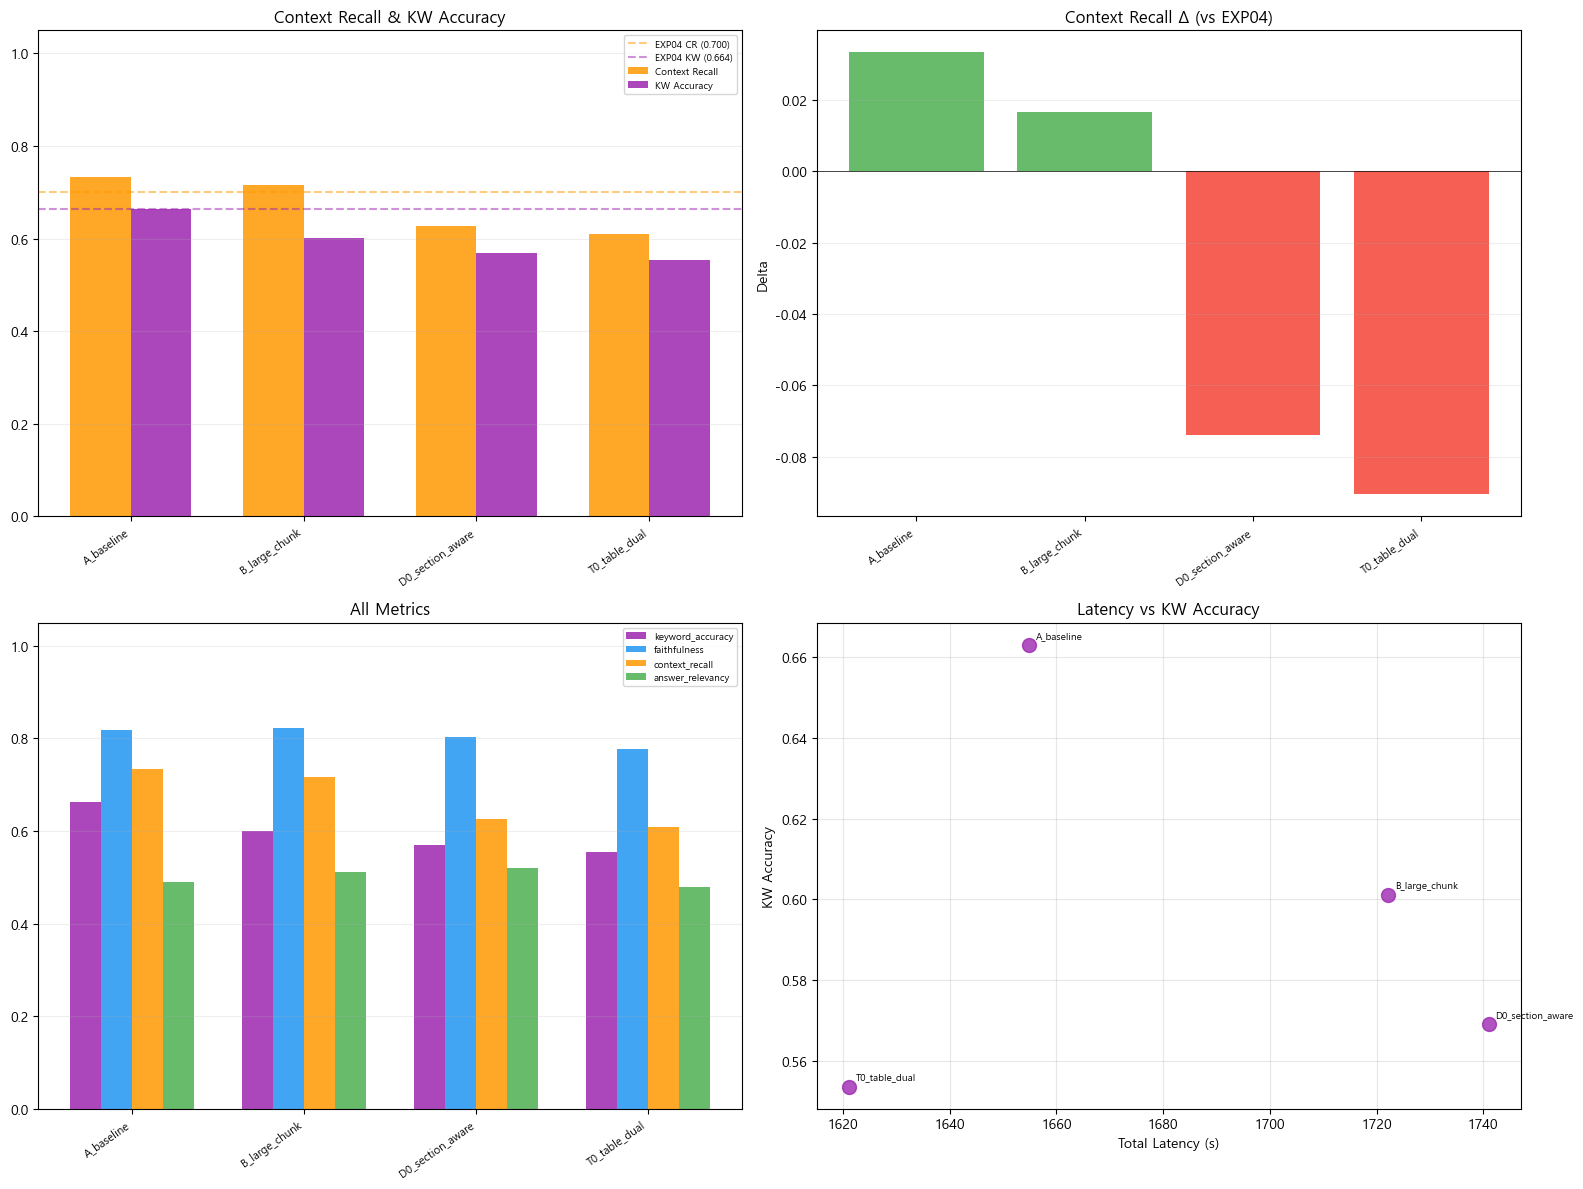

In [19]:
# ============================================================
# 10. 시각화
# ============================================================
if results:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    configs = df['config'].tolist()
    x = np.arange(len(configs))

    # 1. CR + KW_Acc 비교
    width = 0.35
    axes[0, 0].bar(x - width/2, df['context_recall'], width, label='Context Recall', color='#FF9800', alpha=0.85)
    axes[0, 0].bar(x + width/2, df['keyword_accuracy'], width, label='KW Accuracy', color='#9C27B0', alpha=0.85)
    axes[0, 0].axhline(y=exp04_cr, color='#FF9800', linestyle='--', alpha=0.5, label=f'EXP04 CR ({exp04_cr:.3f})')
    axes[0, 0].axhline(y=exp04_kw, color='#9C27B0', linestyle='--', alpha=0.5, label=f'EXP04 KW ({exp04_kw:.3f})')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(configs, rotation=35, ha='right', fontsize=8)
    axes[0, 0].set_title('Context Recall & KW Accuracy', fontsize=12)
    axes[0, 0].legend(fontsize=7)
    axes[0, 0].set_ylim(0, 1.05)
    axes[0, 0].grid(True, alpha=0.2, axis='y')

    # 2. CR Delta (waterfall)
    cr_deltas = [row['context_recall'] - exp04_cr for _, row in df.iterrows()]
    colors = ['#4CAF50' if d >= 0 else '#F44336' for d in cr_deltas]
    axes[0, 1].bar(configs, cr_deltas, color=colors, alpha=0.85)
    axes[0, 1].axhline(y=0, color='black', linewidth=0.5)
    axes[0, 1].set_title('Context Recall Δ (vs EXP04)', fontsize=12)
    axes[0, 1].set_ylabel('Delta')
    axes[0, 1].set_xticklabels(configs, rotation=35, ha='right', fontsize=8)
    axes[0, 1].grid(True, alpha=0.2, axis='y')

    # 3. 전체 메트릭 비교
    metrics = ['keyword_accuracy', 'faithfulness', 'context_recall', 'answer_relevancy']
    m_colors = ['#9C27B0', '#2196F3', '#FF9800', '#4CAF50']
    w = 0.18
    for i, (m, c) in enumerate(zip(metrics, m_colors)):
        axes[1, 0].bar(x + i * w, df[m], w, label=m, color=c, alpha=0.85)
    axes[1, 0].set_xticks(x + w * 1.5)
    axes[1, 0].set_xticklabels(configs, rotation=35, ha='right', fontsize=8)
    axes[1, 0].set_title('All Metrics', fontsize=12)
    axes[1, 0].legend(fontsize=7)
    axes[1, 0].set_ylim(0, 1.05)
    axes[1, 0].grid(True, alpha=0.2, axis='y')

    # 4. Latency vs KW_Acc
    axes[1, 1].scatter(df['latency_total'], df['keyword_accuracy'],
                       s=100, c='#9C27B0', alpha=0.8, zorder=5)
    for _, row in df.iterrows():
        axes[1, 1].annotate(row['config'], (row['latency_total'], row['keyword_accuracy']),
                            textcoords='offset points', xytext=(5, 5), fontsize=7)
    axes[1, 1].set_title('Latency vs KW Accuracy', fontsize=12)
    axes[1, 1].set_xlabel('Total Latency (s)')
    axes[1, 1].set_ylabel('KW Accuracy')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUT_FIG_PATH, dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('[Warning] 시각화할 결과 없음')

## 11. 결론 (Conclusion)

### 11.1 실험 결과 요약

**6개 Config 전체 비교** (EXP04 C_verbatim 대비):

| Config | KW_Acc | Δ | CR | Δ | Faithfulness | Δ |
|--------|--------|---|-----|---|-------------|---|
| **EXP04 C_verbatim** | **0.664** | — | **0.700** | — | **0.829** | — |
| A_baseline | 0.663 | -0.001 | 0.733 | +0.033 | 0.817 | -0.011 |
| B_large_chunk | 0.601 | -0.063 | 0.717 | +0.017 | 0.824 | -0.005 |
| D0_section_aware | 0.569 | -0.095 | 0.626 | -0.074 | 0.803 | -0.026 |
| T0_table_dual | 0.554 | -0.110 | 0.610 | -0.091 | 0.778 | -0.051 |
| C0_parent_child | 0.553 | -0.111 | 0.650 | -0.050 | 0.794 | -0.034 |
| C1_pc_window | 0.480 | -0.184 | 0.500 | -0.200 | 0.758 | -0.071 |

**결과: 모든 검색 아키텍처 변경이 baseline 대비 성능을 악화시킴.**

### 11.2 가설 검증

| 가설 | 결과 | 분석 |
|------|------|------|
| H1: Large Chunk(1000)으로 CR 소폭 개선 | **기각** | CR +0.017이나 KW_Acc -0.063. 큰 청크가 불필요한 텍스트를 포함하여 생성 품질 저하 |
| H2: Section-aware + Header prefix로 구조적 CR 개선 | **기각** | CR -0.074, KW_Acc -0.095. 헤더 감지 17개로 부족하고, chunk_size 800 변경이 기존 분할보다 열위 |
| H3: Table dual-index로 표 질문 정확도 대폭 개선 | **기각** | CR -0.091, KW_Acc -0.110. table-to-text가 검색 노이즈로 작용, 1202개 인덱스에서 관련 없는 표 청크가 top-15 오염 |
| H4: 최종 Config에서 KW_Acc 0.75+ | **기각** | 최고 성능이 baseline(0.663)으로 EXP04와 동일 수준 |

### 11.3 실패 원인 분석

**1. Section-aware (D0/T0) 실패 원인**
- 헤더 감지가 17개에 불과 → RFP 문서의 실제 구조(수백 개 항목)를 대부분 놓침
- `chunk_size=800`으로 변경한 것이 기존 500보다 열위 (경계 미스매치 증가)
- 헤더 프리픽스가 검색 쿼리와 매칭되지 않아 Dense 유사도를 오히려 희석

**2. Table dual-index (T0) 실패 원인**
- table-to-text 변환이 인덱스 크기를 831→1202로 +45% 증가시켜 top-15 경쟁 심화
- 변환된 텍스트("항목: 값, 항목: 값")가 자연어 질문과의 유사도에서 원본 Markdown보다 낮음
- 이미 baseline에서 표 Markdown 원본이 인덱싱되고 있어 이중화 효과 없음

**3. Parent-Child (C0/C1) 실패 원인**
- child=300이 너무 작아 의미 단위가 깨지고 검색 정밀도 하락
- parent=1500이 과도한 컨텍스트를 포함하여 LLM의 정답 추출 효율 저하
- Window(C1)는 인접 parent 추가로 노이즈가 급증 → CR 0.500까지 하락 (최악)

**4. 구조적 한계 (공통)**
- 현재 baseline(chunk=500 + 표 Markdown + Hybrid RRF)이 이미 합리적 수준
- 검색 실패의 실제 병목은 청킹 전략이 아닌, **임베딩 모델의 한국어 RFP 도메인 한계** 또는 **BM25 형태소 분석의 전문용어 처리 한계**일 가능성
- 진단에서 확인한 "87.5% 표 관련 실패"는 청킹 방식 변경으로 해결되지 않음 → Dense/Sparse 검색 자체의 매칭 품질 문제

### 11.4 핵심 발견

1. **Baseline 강건성**: chunk=500 + Hybrid RRF가 검색 아키텍처 변형들보다 일관되게 우수
2. **복잡한 전략의 역효과**: 구조 인식, 이중 인덱싱, Parent-Child 모두 인덱스 노이즈 증가 → 성능 악화
3. **CR 병목의 재정의**: 검색 실패 원인이 청킹이 아닌, 임베딩/BM25 수준의 매칭 품질에 있음
4. **EXP04 C_verbatim이 현 파이프라인의 실질적 최적점** (KW_Acc=0.664, CR=0.700)

### 11.5 다음 단계 제안

현재까지의 실험 결과를 종합하면, **청킹/검색 아키텍처 수준의 변경으로는 CR 0.70 병목을 돌파하기 어려움**. 다음 방향 검토 필요:

1. **임베딩 모델 교체**: 한국어 특화 임베딩(예: multilingual-e5-large, KoSimCSE) 또는 domain-fine-tuned 모델로 Dense 검색 품질 자체를 개선
2. **BM25 형태소 분석 개선**: 현재 기본 토크나이저 대신 한국어 형태소 분석기(Mecab/Komoran) 적용
3. **Reranker 도입**: 검색 후 Cross-encoder 기반 재정렬로 top-15 품질 향상 (EXP04에서 LLM Reranker는 테스트했으나 Cross-encoder는 미검증)
4. **테스트셋 품질 검증**: Golden testset의 ground_truth가 문서 원문과 정확히 대응하는지 재검토

In [20]:
# ============================================================
# 12. 리포트 저장
# ============================================================
if results:
    df_sorted = df.sort_values(by=['keyword_accuracy', 'context_recall'], ascending=False)
    best = df_sorted.iloc[0].to_dict()

    v2_comparison = {
        'exp04_keyword_accuracy': exp04_kw,
        'exp04_context_recall': exp04_cr,
        'exp04_faithfulness': exp04_faith,
        'best_keyword_accuracy': best['keyword_accuracy'],
        'best_context_recall': best['context_recall'],
        'best_faithfulness': best['faithfulness'],
        'kw_delta': best['keyword_accuracy'] - exp04_kw,
        'cr_delta': best['context_recall'] - exp04_cr,
        'faith_delta': best['faithfulness'] - exp04_faith,
    }

    report = {
        'meta': {
            'experiment': 'Exp-04-v2 Retrieval Architecture Enhancement',
            'version': 'v3.1',
            'date': datetime.now().isoformat(),
            'sample_file': SAMPLE_FILE,
            'num_test_cases': len(golden_df),
            'prerequisite': {
                'exp04_best': exp04_best['config'],
                'exp04_kw_acc': exp04_kw,
                'exp04_cr': exp04_cr,
                'alpha': ALPHA,
                'top_k': TOP_K,
                'gen_model': GEN_MODEL,
                'prompt': 'VERBATIM + Fact Sheet',
            },
            'diagnostic': {
                'retrieval_miss_count': int(diag_df['is_retrieval_miss'].sum()),
                'neighbor_gain_avg': float(diag_df['neighbor_gain'].mean()),
                'table_answer_count': int(diag_df['has_table_answer'].sum()),
            },
            'run_config': {'timeout': 300, 'max_workers': 2},
        },
        'best_config': {
            'config': best['config'],
            'description': best['description'],
            'keyword_accuracy': float(best['keyword_accuracy']),
            'faithfulness': float(best['faithfulness']),
            'context_recall': float(best['context_recall']),
            'answer_relevancy': float(best['answer_relevancy']),
        },
        'v2_comparison': v2_comparison,
        'results': [{k: v for k, v in r.items()
                     if k not in ('answers', 'per_question')}
                    for r in results],
    }

    with open(OUT_REPORT_PATH, 'w', encoding='utf-8') as f:
        json.dump(report, f, indent=2, ensure_ascii=False)
    print(f'[Saved] Report: {OUT_REPORT_PATH}')

    df.to_csv(OUT_CSV_PATH, index=False, encoding='utf-8-sig')
    print(f'[Saved] CSV: {OUT_CSV_PATH}')

    print(f'\n{"=" * 60}')
    print(f'[Summary] EXP04-v2 완료')
    print(f'{"=" * 60}')
    print(f'  Best: {best["config"]} ({best["description"]})')
    print(f'  KW_Acc:  {best["keyword_accuracy"]:.4f} (vs EXP04: {v2_comparison["kw_delta"]:+.4f})')
    print(f'  CR:      {best["context_recall"]:.4f} (vs EXP04: {v2_comparison["cr_delta"]:+.4f})')
    print(f'  Faith:   {best["faithfulness"]:.4f} (vs EXP04: {v2_comparison["faith_delta"]:+.4f})')
else:
    print('[Warning] 저장할 결과 없음')

[Saved] Report: ../data/experiments/exp04v2_report.json
[Saved] CSV: ../data/experiments/exp04v2_results.csv

[Summary] EXP04-v2 완료
  Best: A_baseline (Baseline (chunk=500))
  KW_Acc:  0.6630 (vs EXP04: -0.0010)
  CR:      0.7333 (vs EXP04: +0.0333)
  Faith:   0.8174 (vs EXP04: -0.0113)
